## Final Project Submission

Please fill out:
* Student name: Louis Bademosi
* Student pace: Full time
* Scheduled project review date/time: 
* Instructor name:
* Blog post URL:


# Project Overview

- quick overwiev of my approach to the project
My three business questions:
1. Is the average house size increasing over the years? 
2. Does a change in house age have a correlation with the land space that houses are built on?
3. What metrics are good predictors of house prices?

# Import Data

In [90]:
import datetime
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
''' 
Importing the data. By the project specifications I will be dropping these columns from the get go: 
date
view
sqft_above
sqft_basement
yr_renovated
zipcode
lat
long
sqft_living15
sqft_lot15 
'''

df = pd.read_csv('kc_house_data.csv')
drop_vars = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated',
             'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

df.drop(columns=drop_vars, inplace=True)
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987


In [4]:
df.shape

(21597, 11)

# Light exploration & Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
id             21597 non-null int64
price          21597 non-null float64
bedrooms       21597 non-null int64
bathrooms      21597 non-null float64
sqft_living    21597 non-null int64
sqft_lot       21597 non-null int64
floors         21597 non-null float64
waterfront     19221 non-null float64
condition      21597 non-null int64
grade          21597 non-null int64
yr_built       21597 non-null int64
dtypes: float64(4), int64(7)
memory usage: 1.8 MB


In [6]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,3.409825,7.657915,1970.999676
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.650546,1.173200,29.375234
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,1900.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1951.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,3.000000,7.000000,1975.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,4.000000,8.000000,1997.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,2015.000000


### Errors in the data to look for/clean:
- Correct 'waterfront' null values
- The 177 duplicates found
- Check data abides by the 3 laws of tidy data. Columns = variables, rows = single obvservations and dataframes contain a single theme of data (I can already confirm it does)
- Remove outliers based on inter quartile ranges as this data set seems to have a large amount of range in some of the variables. Using measures of dispersion about the median instead of the mean will reduce the effects of extreme results. Alternatively standard deviations could be used

In [7]:
# looking for duplicates and null values

dup = df['id'].duplicated().sum()
print(df.isnull().sum())
print(f'Number of duplicates: {dup}')

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64
Number of duplicates: 177


In [8]:
# 'waterfront' column contains 0 or 1's denoting yes or no for whether or not the house has a waterfront
# Expectedly most houses do not have one, so the null values will be filled with 0's

df.fillna({'waterfront': 0.0}, inplace=True)
df.isnull().sum()

id             0
price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
condition      0
grade          0
yr_built       0
dtype: int64

In [9]:
df['waterfront'].duplicated().sum()

21595

In [10]:
# duplicates wil be dropped
df.drop_duplicates(subset='id', keep='first', inplace=True)

In [11]:
# Rounding the values ending in 0.5 up, so that all floors are counted as 1 whole floor
df['floors'] = df['floors'].apply(lambda x: x+0.5 if str(x)[2] != '0' else x)

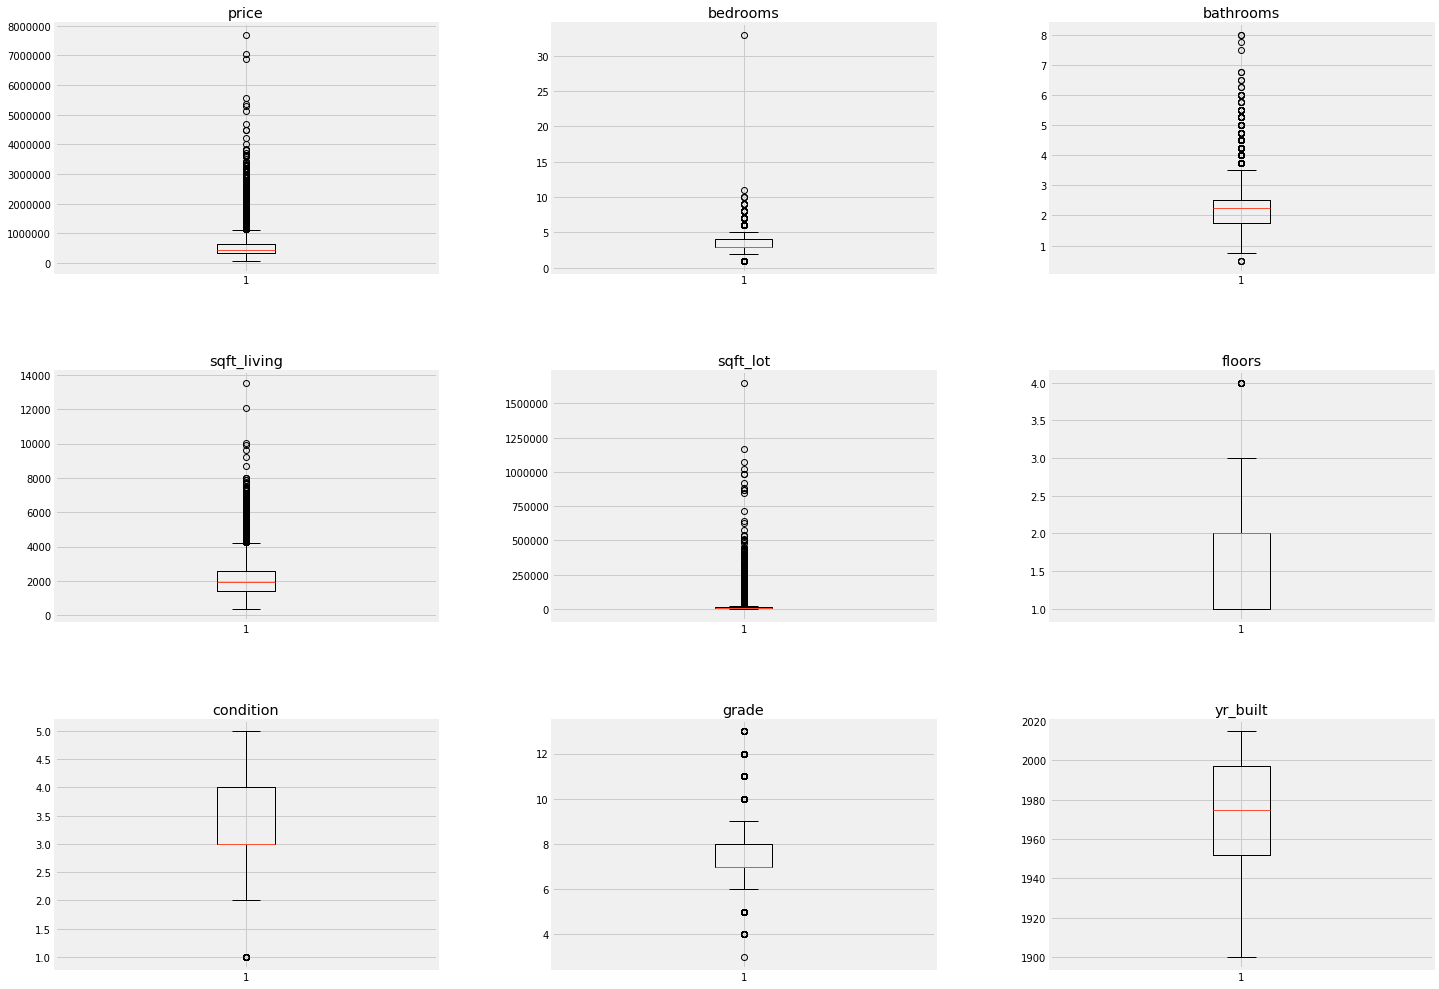

In [12]:
# Using box plots to identify outliers that should not be there or any extreme values that should be there but still
# need to be taken into consideration

fig, axs = plt.subplots(3, 3, figsize=(22,15))
fig.subplots_adjust(wspace=0.3, hspace=0.4, top=1)

#1st row
axs[0,0].boxplot(df['price'])
axs[0,0].set_title('price')

axs[0,1].boxplot(df['bedrooms'])
axs[0,1].set_title('bedrooms')

axs[0,2].boxplot(df['bathrooms'])
axs[0,2].set_title('bathrooms')

# 2nd row
axs[1,0].boxplot(df['sqft_living'])
axs[1,0].set_title('sqft_living')

axs[1,1].boxplot(df['sqft_lot'])
axs[1,1].set_title('sqft_lot')

axs[1,2].boxplot(df['floors'])
axs[1,2].set_title('floors')

# 3rd row
axs[2,0].boxplot(df['condition'])
axs[2,0].set_title('condition')

axs[2,1].boxplot(df['grade'])
axs[2,1].set_title('grade')

axs[2,2].boxplot(df['yr_built'])
axs[2,2].set_title('yr_built')

plt.show();

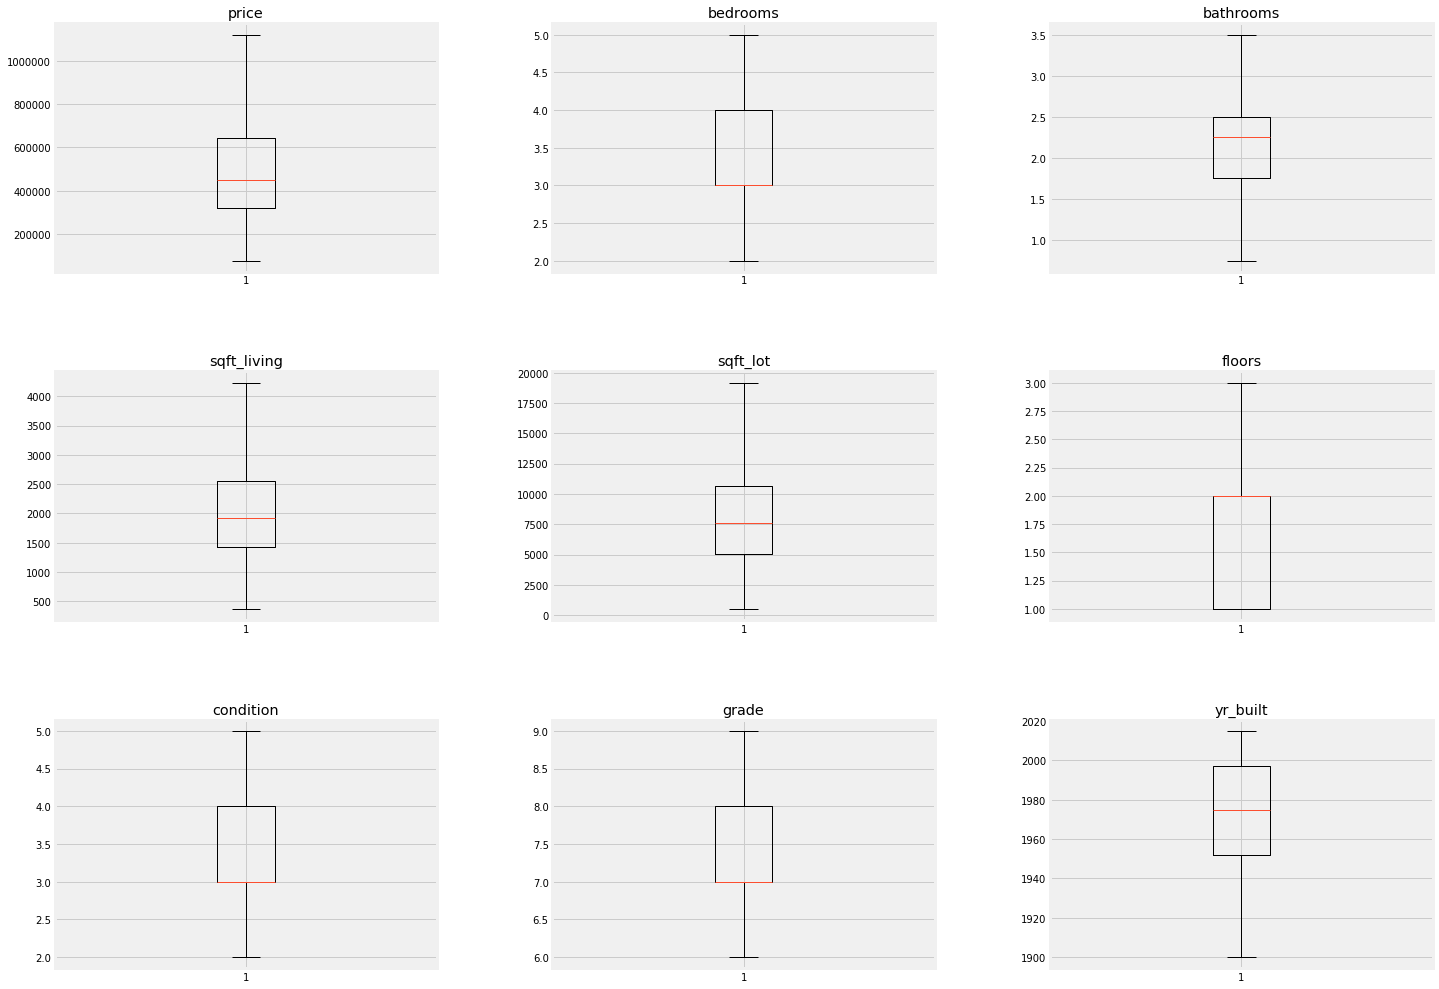

In [13]:
# The same plots without the outliers so the dispersion of the data is visible

fig, axs = plt.subplots(3, 3, figsize=(22,15))
fig.subplots_adjust(wspace=0.3, hspace=0.4, top=1)

#1st row
axs[0,0].boxplot(df['price'], showfliers=False)
axs[0,0].set_title('price')

axs[0,1].boxplot(df['bedrooms'], showfliers=False)
axs[0,1].set_title('bedrooms')

axs[0,2].boxplot(df['bathrooms'], showfliers=False)
axs[0,2].set_title('bathrooms')

# 2nd row
axs[1,0].boxplot(df['sqft_living'], showfliers=False)
axs[1,0].set_title('sqft_living')

axs[1,1].boxplot(df['sqft_lot'], showfliers=False)
axs[1,1].set_title('sqft_lot')

axs[1,2].boxplot(df['floors'], showfliers=False)
axs[1,2].set_title('floors')

# 3rd row
axs[2,0].boxplot(df['condition'], showfliers=False)
axs[2,0].set_title('condition')

axs[2,1].boxplot(df['grade'], showfliers=False)
axs[2,1].set_title('grade')

axs[2,2].boxplot(df['yr_built'], showfliers=False)
axs[2,2].set_title('yr_built')

plt.show();

### Thoughts on the box plots:
Overall it is clear that this data set has very large amounts of range in its values. I believe that the majority of these extreme values are due to the nature of the dataset I am working with. Houses can vary so greatly, especially the more expensive ones. Here you can expect to see houses that will be more than 3 standard deviations away from the norm in metrics such as price, size, bedrooms, grade etc. <br>
I believe the extreme values in the data set are due to the extremely luxurious or large houses in the data set and should not be treated as anomolies, but should be taken into consideration when carrying out further analysis as these data points could drastically effect any results later on

# Feature Engineering

__Features I will create:__ <br><br>
_1. Create a psudo-volume column:_ acting as a rough estimate comparison between the size of the houses. 'sqft_livng' is the area of the house's ground floor, multiplying that by the house's height will give you its volume (roughly). The 'floors' variable is used as a rough estimation of the house's height. <br> I am interested to see how this effects the model's results. I am also expecting some form of colinearity between the 'psudo_volume' and its constituent variables <br><br>
_2. Create a total rooms column:_ as an all round representation of the number of rooms <br><br>
_3. Create an age column:_ that will calculate the age of the house based on the current year that this notebook is run in

In [14]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987


In [15]:
# Creating a psudo volume column which is the product of the 'floors' and 'sqft_living' variables
df['psudo_volume'] = df['floors'] * df['sqft_living']

In [16]:
# Creating a total rooms column that is a sum of the bathrooms and bedrooms in the house

df['total_rooms'] = df['bedrooms'] + df['bathrooms']

In [17]:
# Creating an age column that will be accurate to the current year

current_yr = datetime.date.today().year
df['age'] = current_yr - df['yr_built']

In [18]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,psudo_volume,total_rooms,age
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955,1180.0,4.00,65
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951,5140.0,5.25,69
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933,770.0,3.00,87
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965,1960.0,7.00,55
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987,1680.0,5.00,33


# EDA

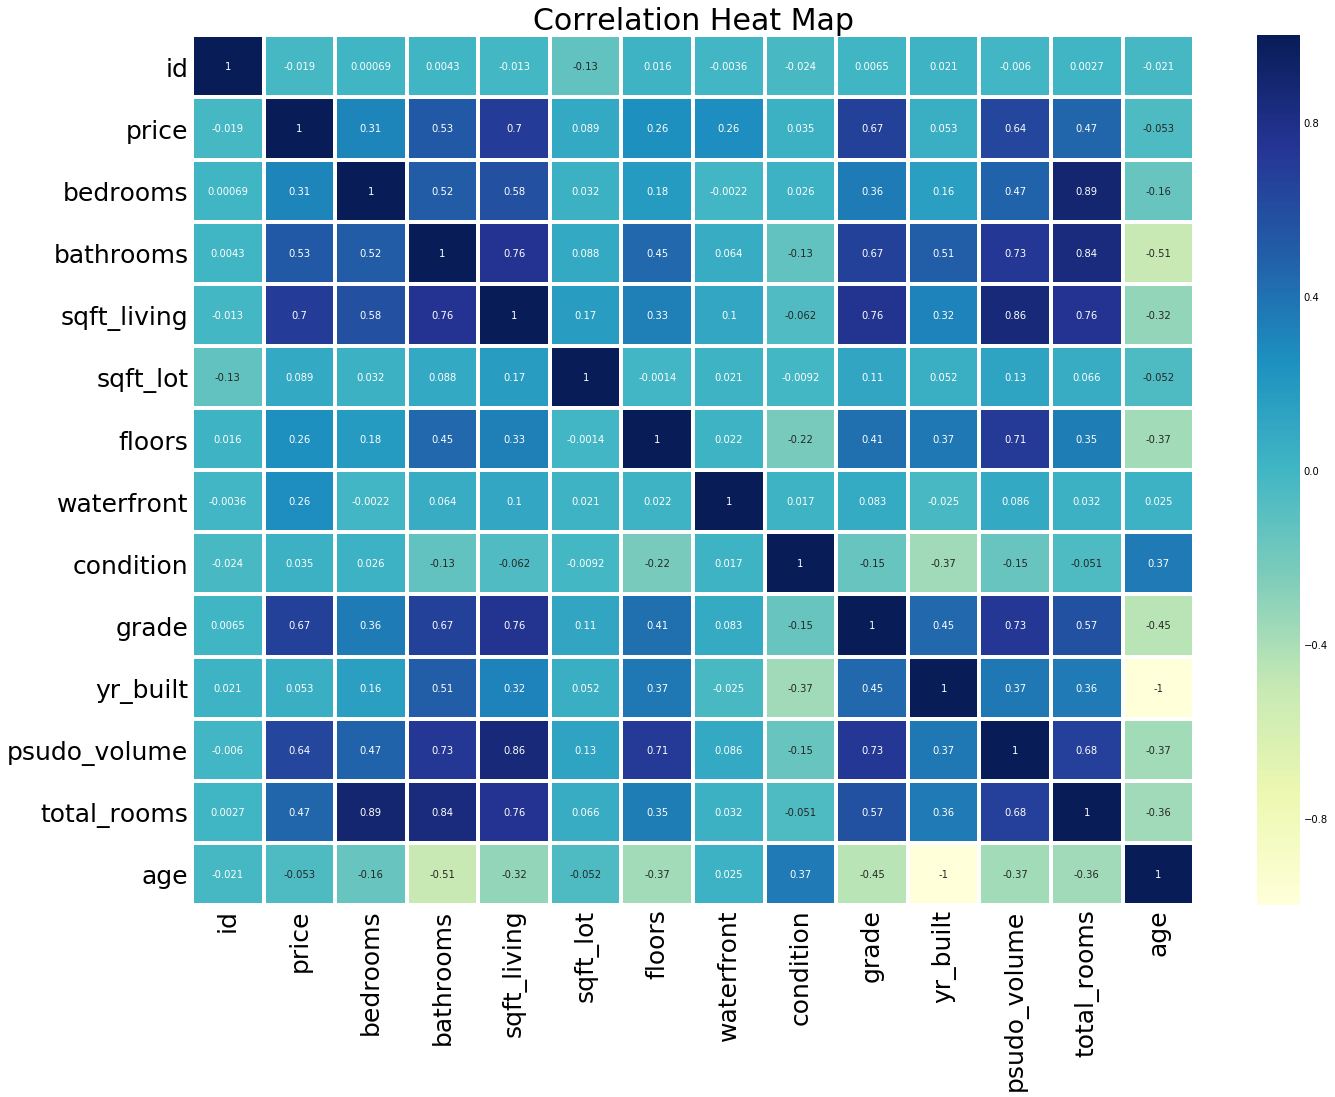

In [23]:
# To gain an idea of the correlations between the variables. This will help to identify features that could be  
# good predictors of house price (the 3rd question)

df_corr = df.corr()
fig, ax = plt.subplots(figsize=(20,16))
ax.set_title('Correlation Heat Map', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
sns.heatmap(df_corr, linewidths=3, cmap="YlGnBu", annot=True)
plt.show();

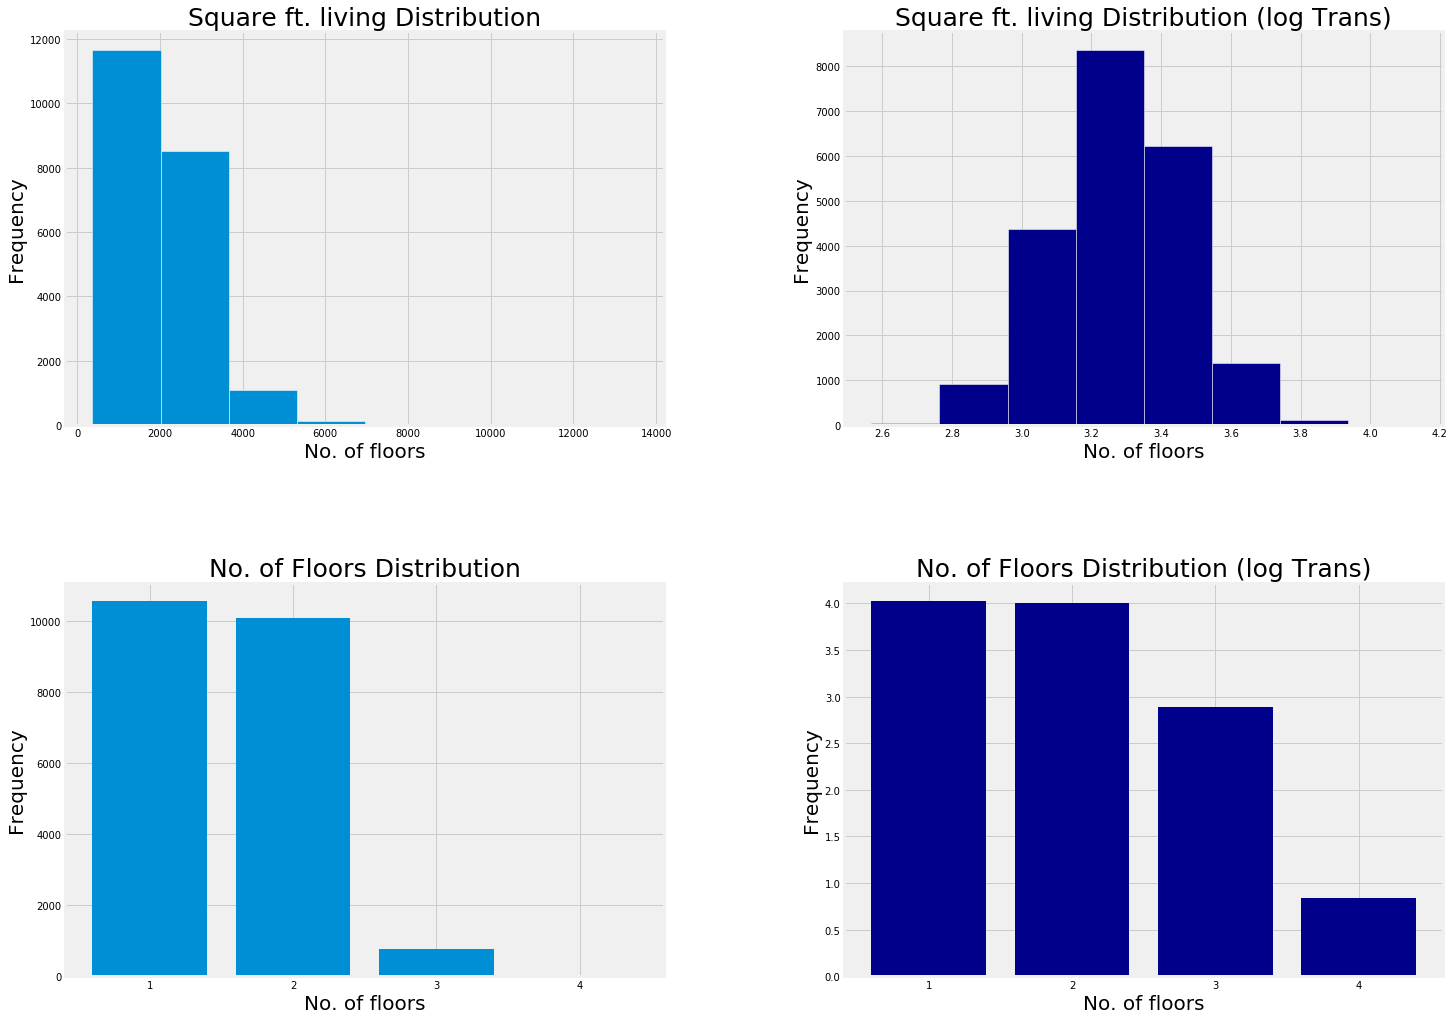

In [20]:
# Simple exploratory plots to give me an some insight into the data. Also a chance to experiment with transformations

fig, axs = plt.subplots(2, 2, figsize=(22,15))
fig.subplots_adjust(wspace=0.3, hspace=0.4, top=1)
val_counts = {}
for i in df['floors']:
    val_counts[i] = val_counts.get(i, 0) +1
bar_x = [x[0] for x in val_counts.items()]
bar_y = [x[1] for x in val_counts.items()]

# A frequency dist of square ft living areas
axs[0, 0].hist(df['sqft_living'], bins=8, edgecolor='white')
axs[0, 0].set_title('Square ft. living Distribution', fontsize=25)
axs[0, 0].set_xlabel('No. of floors', fontsize=20)
axs[0, 0].set_ylabel('Frequency', fontsize=20)

# A frequency dist of square ft living areas, log transformed to better be able to see the spread
# of data about the mean
axs[0, 1].hist(df['sqft_living'].transform(np.log10), bins=8, edgecolor='white', color='darkblue')
axs[0, 1].set_title('Square ft. living Distribution (log Trans)', fontsize=25)
axs[0, 1].set_xlabel('No. of floors', fontsize=20)
axs[0, 1].set_ylabel('Frequency', fontsize=20)

# A frequency distribution of the number of floors
axs[1, 0].bar(bar_x, bar_y)
axs[1, 0].set_title('No. of Floors Distribution', fontsize=25)
axs[1, 0].set_xticks(bar_x)
axs[1, 0].set_xlabel('No. of floors', fontsize=20)
axs[1, 0].set_ylabel('Frequency', fontsize=20)

# A log transformation of the y axis of the frequency distribution, such that the smaller
# differences between 3 and 4 floors are easily visible
axs[1, 1].bar(bar_x, np.log10(bar_y), color='darkblue')
axs[1, 1].set_title('No. of Floors Distribution (log Trans)', fontsize=25)
axs[1, 1].set_xticks(bar_x)
axs[1, 1].set_xlabel('No. of floors', fontsize=20)
axs[1, 1].set_ylabel('Frequency', fontsize=20)

plt.show();

### Are newly built houses getting smaller in size?

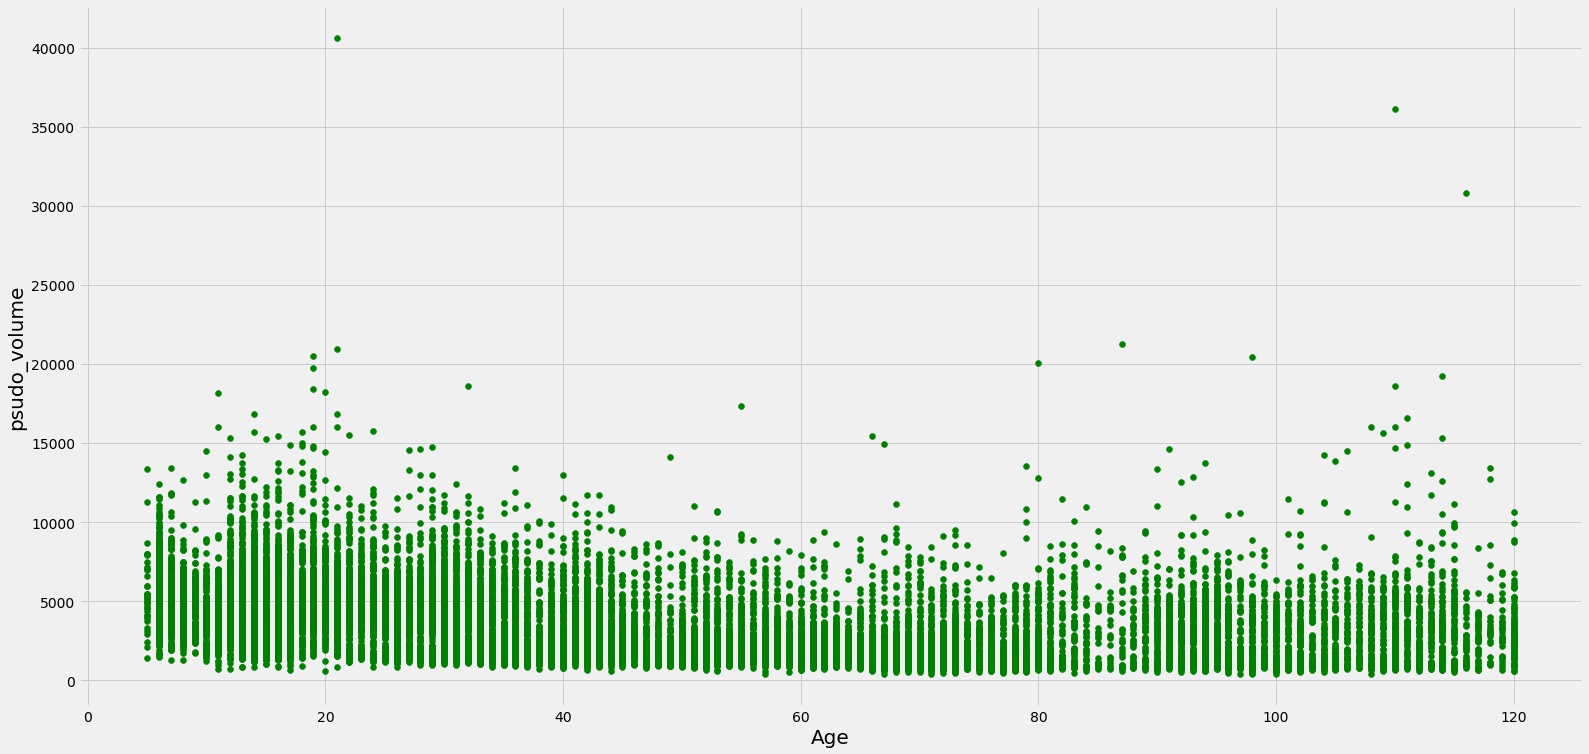

In [45]:
fig, ax = plt.subplots(figsize=(24,12))

ax.scatter(df['age'], df['psudo_volume'], color='green')
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('psudo_volume', fontsize=20)

plt.show();

There appears to be no correlation between the variables here but I beleive this could be because: 
1. the psudo volume is on a much larger scale than the age with values in the tens of thousands while the largest value in the age sample 120
2. The psudo volume variable is a rough estimate of house volume where the sqft living is multiplied by the number of floors the house has. This means it has no real metric and is just a representative value that allows comparison between the values themeselves but can not be compared to other variables like volume in $m^3$ for instance.
<br><br>
To work around this I will z transform the data as this will place both variables on the same scale allowing comparison.

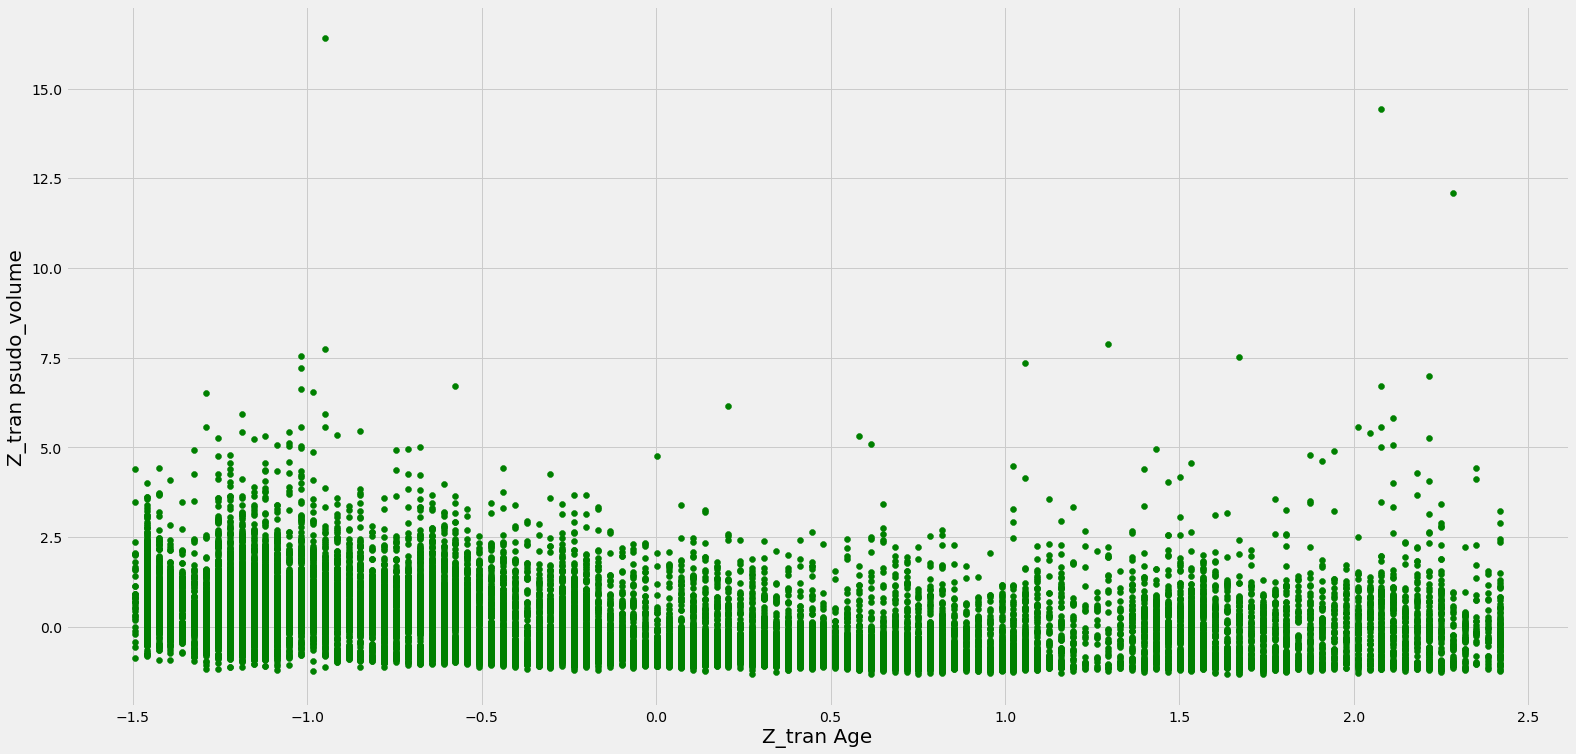

In [46]:
zscore_age = stats.zscore(df['age'])
zscore_psuvol = stats.zscore(df['psudo_volume'])

fig, ax = plt.subplots(figsize=(24,12))

ax.scatter(zscore_age, zscore_psuvol, color='green')
ax.set_xlabel('Z_tran Age', fontsize=20)
ax.set_ylabel('Z_tran psudo_volume', fontsize=20)

plt.show();

Still no noticeable trend between the two variables. Although we do get a negative correlation of -0.37 when we check with a correlation method

In [49]:
df[['age', 'psudo_volume']].corr()

,age,psudo_volume
age,1.000000,-0.373955
psudo_volume,-0.373955,1.000000


### Does a change in house age have a correlation with the land space that houses are built on?

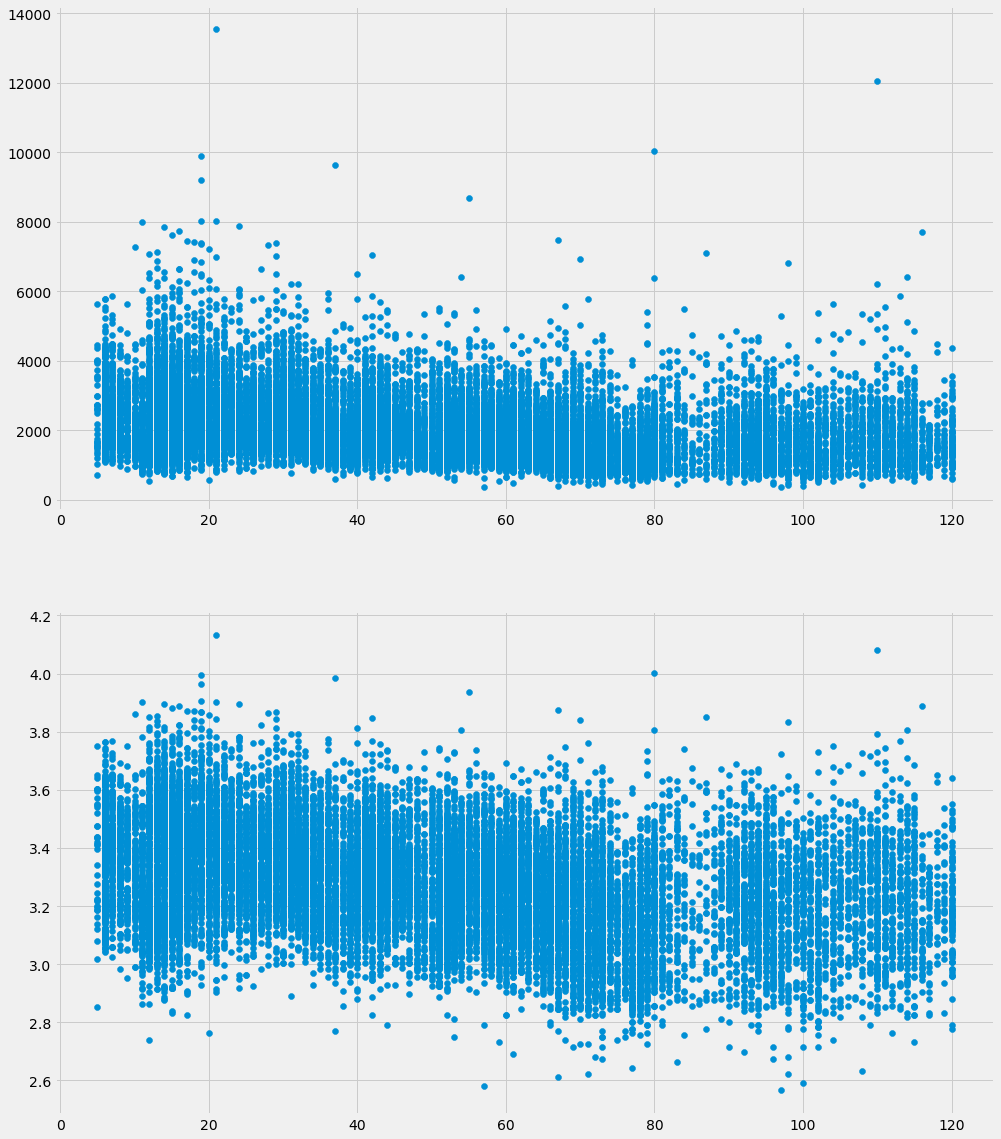

In [72]:
fig, axs = plt.subplots(2, figsize=(15,19))
axs[0].scatter(df['age'], df['sqft_living'])
axs[1].scatter(df['age'], df['sqft_living'].transform(np.log10))
plt.show();

# Modelling

### What metrics can accurately predict House prices?

In [99]:
# The train - test split
df = sm.add_constant(df)
train_df, test_df = model_selection.train_test_split(df, test_size=0.3)
print(train_df.shape)
print(test_df.shape)

(14994, 15)
(6426, 15)


In [100]:
# Creating the base model
predictor = train_df.drop(columns=['id', 'price'])
response = train_df['price']
model = sm.OLS(response, predictor)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     2787.
Date:                Thu, 26 Mar 2020   Prob (F-statistic):               0.00
Time:                        19:07:26   Log-Likelihood:            -2.0576e+05
No. Observations:               14994   AIC:                         4.115e+05
Df Residuals:                   14983   BIC:                         4.116e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.3526      0.037     36.441      0.000       1.280       1.425
bedrooms     -4.554e+04   2336.953    -19.487      0.000   -5.01e+04    -4.1e+04
bathrooms     5.073e+04   3034.969     16.716      0.000    4.48e+04    5.67e+04
sqft_living     88.7724      7.933     11.190      0.000      73.223     104.322
sqft_lot        -0.2382      0.045     -5.251      0.000      -0.327      -0.149
floors       -8.156e+04   8332.031     -9.789      0.000   -9.79e+04   -6.52e+04
waterfront    7.916e+05    2.2e+04     35.996      0.000    7.48e+05    8.35e+05
condition     2.209e+04   3020.046      7.315      0.000    1.62e+04     2.8e+04
grade         1.311e+05   2610.910     50.207      0.000    1.26e+05    1.36e+05
yr_built      -460.2591     11.834    -38.892      0.000    -483.456    -437.063
psudo_volume    49.9708      3.747     13.336      0.000      42.626      57.315
total_rooms   5193.1019   1494.202      3.476      0.001    2264.284    8121.920
age           3192.5418     76.313     41.835      0.000    3042.959    3342.124
==============================================================================
Omnibus:                    10532.928   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           554249.810
Skew:                           2.797   Prob(JB):                         0.00
Kurtosis:                      32.255   Cond. No.                     2.04e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.8e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Model Analysis:
- $R^2$ value: returned 0.64 which is not a bad start but could most likely be better
- P values: all variables returned significant p values and so can be deemed statistically significant as a predictor of price. Although this does not mean that the variables *are* a good predictor of price and must be checked for colinearity and any violations of the assumptions of ordinary least squares
- Coefficients: most of the coefficients are astronomically high values and will need to be normalised before any comparisons can be made
- AIC: 4.106e+05 - I will be casually monitoring the AIC/BIC results to see if it offers any help during the feature selection process as a precautionary measure to over fitting
<br><br>
using an alpha of 0.05

In [114]:
# Checking for colinearity with variance inflation factors as a correlation matrix can expose colinearities between
# pairs of variables outside of their use in the model, but it is possible to have multicolinearity occur between
# more than 2 variables when used in a regression model even if they didn't show colinearities in their isolated pairs

vif_df = pd.DataFrame()
vif_df['features'] = train_df.columns
vif_df['vif'] = [variance_inflation_factor(train_df.values, i) for i in range(train_df.shape[1])]
vif_df

,features,vif
0,const,0.000000
1,id,1.020286
2,price,2.860804
3,bedrooms,inf
4,bathrooms,inf
5,sqft_living,16.541260
6,sqft_lot,1.066652
7,floors,6.869951
8,waterfront,1.114933
9,condition,1.190866


In [130]:
# Any features between 5 - 10 will be discarded. infinity values will be ignored as I'm not sure why they are there

drop_cols = ['id', 'price']
for i, val in enumerate(vif_df['vif']):
    if val == np.infty:
        pass
    elif val >= 5:
        drop_cols.append(vif_df.loc[i, 'features'])
    else:
        pass
    
drop_cols

['id', 'price', 'sqft_living', 'floors', 'psudo_volume']

In [134]:
# re fitting the model without the features containing high variance inflation factors
predictor = train_df.drop(columns=drop_cols)
response = train_df['price']
model = sm.OLS(response, predictor)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     3193.
Date:                Thu, 26 Mar 2020   Prob (F-statistic):               0.00
Time:                        19:56:10   Log-Likelihood:            -2.0679e+05
No. Observations:               14994   AIC:                         4.136e+05
Df Residuals:                   14986   BIC:                         4.137e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4082      0.040     35.575      0.000       1.331       1.486
bedrooms    -4.598e+04   2480.753    -18.533      0.000   -5.08e+04   -4.11e+04
bathrooms    9.007e+04   3040.155     29.627      0.000    8.41e+04     9.6e+04
sqft_lot        0.0853      0.048      1.780      0.075      -0.009       0.179
waterfront   8.886e+05   2.34e+04     37.893      0.000    8.43e+05    9.35e+05
condition    2.009e+04   3207.894      6.263      0.000    1.38e+04    2.64e+04
grade        1.997e+05   2258.490     88.421      0.000    1.95e+05    2.04e+05
yr_built     -770.8340      9.449    -81.581      0.000    -789.355    -752.313
total_rooms  4.409e+04   1219.558     36.155      0.000    4.17e+04    4.65e+04
age          3615.3341     80.863     44.709      0.000    3456.832    3773.836
==============================================================================
Omnibus:                    12340.615   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1015658.130
Skew:                           3.441   Prob(JB):                         0.00
Kurtosis:                      42.728   Cond. No.                     2.03e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.81e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Model Analysis:
- $R^2$ value: returned 0.599 which is lower than the base
- P values: 'sqft_lot' is now statistically insignificant with p values higher than 0.05
- Coefficients: are still large but most of them are positive meaning each unit increase in that independent variable will lead to an increase in the dependent variable
- AIC: 4.136e+05 - has risen in comparison to the base which indicates that the previous model may have been better. 
<br><br>
The lower $R^2$ values and higher AIC results with the presence of a statistically insignificant variable in this model all make the base model seem like a better selection. But the potential presence of multicolinearity may have deemed it an ineffective model

In [135]:
# re fitting the model minus the sqft_lot
drop_cols.append('sqft_lot')
predictor = train_df.drop(columns=drop_cols)
response = train_df['price']
model = sm.OLS(response, predictor)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     3724.
Date:                Thu, 26 Mar 2020   Prob (F-statistic):               0.00
Time:                        19:56:35   Log-Likelihood:            -2.0680e+05
No. Observations:               14994   AIC:                         4.136e+05
Df Residuals:                   14987   BIC:                         4.137e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4077      0.040     35.561      0.000       1.330       1.485
bedrooms    -4.608e+04   2480.308    -18.577      0.000   -5.09e+04   -4.12e+04
bathrooms    9.019e+04   3039.659     29.670      0.000    8.42e+04    9.61e+04
waterfront   8.891e+05   2.34e+04     37.918      0.000    8.43e+05    9.35e+05
condition     2.01e+04   3208.117      6.267      0.000    1.38e+04    2.64e+04
grade            2e+05   2251.515     88.836      0.000    1.96e+05    2.04e+05
yr_built     -771.4480      9.443    -81.695      0.000    -789.958    -752.938
total_rooms  4.411e+04   1219.603     36.168      0.000    4.17e+04    4.65e+04
age          3614.9748     80.869     44.702      0.000    3456.462    3773.488
==============================================================================
Omnibus:                    12333.592   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1012902.914
Skew:                           3.438   Prob(JB):                         0.00
Kurtosis:                      42.674   Cond. No.                     9.26e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.8e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Model Analysis:
- $R^2$ value: returned 0.599, same as the previous model
- P values: all variables returned significant p values and so can be deemed statistically significant as a predictor of price
- Coefficients: still need to be normalised
- AIC: 4.137e+05 - again not much change and very high

The next step will be to check the data doesn't violate the assumptions of linear regression. So it must have:
1. A Linear relationship
2. No or little multicollinearity (already tested for)
3. Homoscedasticity
<br><br>
Then finally, any extreme values in the data will be removed and the effects this has on the model will be noted. Variables will also be normalised such that the coefficients can be compared on the same scale in order to find which variables have the greatest effect on the price

### Model vs. Test split

In [136]:
# Testing the model
test_predictor = test_df.drop(columns=drop_cols)
test_response = test_df['price']
model = sm.OLS(response, predictor)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     3724.
Date:                Thu, 26 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:14:11   Log-Likelihood:            -2.0680e+05
No. Observations:               14994   AIC:                         4.136e+05
Df Residuals:                   14987   BIC:                         4.137e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4077      0.040     35.561      0.000       1.330       1.485
bedrooms    -4.608e+04   2480.308    -18.577      0.000   -5.09e+04   -4.12e+04
bathrooms    9.019e+04   3039.659     29.670      0.000    8.42e+04    9.61e+04
waterfront   8.891e+05   2.34e+04     37.918      0.000    8.43e+05    9.35e+05
condition     2.01e+04   3208.117      6.267      0.000    1.38e+04    2.64e+04
grade            2e+05   2251.515     88.836      0.000    1.96e+05    2.04e+05
yr_built     -771.4480      9.443    -81.695      0.000    -789.958    -752.938
total_rooms  4.411e+04   1219.603     36.168      0.000    4.17e+04    4.65e+04
age          3614.9748     80.869     44.702      0.000    3456.462    3773.488
==============================================================================
Omnibus:                    12333.592   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1012902.914
Skew:                           3.438   Prob(JB):                         0.00
Kurtosis:                      42.674   Cond. No.                     9.26e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.8e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Conclusion

The final model performed very similarly with the test split in comparison to the training split. Because the model explained 59% of the training data and the same for the test data, I am inclined to think that this is a sign the model had not been overfitted but could also be a sign it has been underfitted. With further refinement of the model it may be able to explain much more of the variability in the data. Access to other features will also improve the models capabilities such as the price of each sale to-date, for each house.